In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
from timeit import default_timer as timer
import matplotlib
from matplotlib.legend_handler import HandlerLine2D

In [2]:
# Flag for controlling zero-point of analysis
# Consider a transition occuring between year y and the next year y+1
# If True, the "zero-year" of transition is the year after the LULC conversion (y+1)
# If False, it is the year before (y)
ZERO_YEAR_AFTER = True

In [3]:

res_year_range = np.arange(1985, 2020)
mb_year_range = np.arange(1985, 2020)

In [4]:
mb_keys_dict = {
    'crop': np.array([18,19,39,20,40,62,41,36,46,47,35,48]),
    'forest': np.array([3]),
    'savanna': np.array([4]),
    'grassland':np.array([12]),
    'pasture': np.array([15])
}

In [5]:
def read_process_lulc_csv(csv):
    df = pd.read_csv(csv, index_col=0)
    df = df.loc[:, df.columns[-1]]
    lulc_y = int(df.name[44:48]) # For all of mato grosso

    df = pd.DataFrame(list(df.apply(eval).values), index=df.index)
    df.columns = pd.MultiIndex.from_product([[lulc_y], df.columns])
    return df

def summarize_lulc(year_df):
    out_df = pd.DataFrame()
    for lulc_class in mb_keys_dict.keys():
        sum_of_class = year_df.loc[:, np.in1d(year_df.columns, mb_keys_dict[lulc_class])].sum(axis=1)
        out_df[lulc_class] = sum_of_class
    return out_df

def classify_lulc(lulc_counts_df):

    natural_covers = ['forest', 'grassland', 'savanna']
    ag_covers = ['crop','pasture']
    natural_df = lulc_counts_df[natural_covers]
    ag_df = lulc_counts_df[ag_covers]
    ag_sum = ag_df.sum(axis=1)
    natural_sum = natural_df.sum(axis=1)
    is_natural = ((ag_sum < 1000) & (natural_sum> 1000))
    natural_cover = natural_df.loc[is_natural].idxmax(axis=1)
    is_ag = ((~is_natural) & (ag_sum > 1000))
    ag_cover = ag_df.loc[is_ag].idxmax(axis=1)
    lulc_counts_df['class'] = 'other'
    lulc_counts_df.loc[is_ag, 'class'] = ag_cover
    lulc_counts_df.loc[is_natural, 'class'] = natural_cover
    return lulc_counts_df['class']

def calc_lulc_full(df):
    new_df = pd.DataFrame(df.index).set_index('id_in_tile')

    for y in df.columns.levels[0]:
        year_df = summarize_lulc(df[y])
        year_df.index = df.index
        classes = classify_lulc(year_df)
        new_df.loc[:, y] = classes
        
    return new_df

def process_year_lulc(y):
    all_csvs = glob.glob('./out/full/lulc_stats_*_res_{}_mb_*_counts.csv'.format(y))
    all_csvs.sort()
    areas = pd.read_csv(all_csvs[0])['area'].values
    full_df = pd.concat([read_process_lulc_csv(csv) for csv in all_csvs], axis=1)
    lulc_df = calc_lulc_full(full_df)
    lulc_df['area'] = areas
    return lulc_df

In [6]:

for y in res_year_range:
    lulc_y_csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(y)
    if not os.path.isfile(lulc_y_csv):
        lulc_y_df = process_year_lulc(y)
        lulc_y_df.to_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(y))


# Helper functions/data for calculating years since/before transitions

In [7]:
lulc_transitions_area_df = pd.read_csv('./out/lulc_summaries/lulc_transitions_yearof_only.csv')
lulc_transitions_area_df['year'] = lulc_transitions_area_df['year'].astype(int)
lulc_transitions_area_df = lulc_transitions_area_df.set_index('year')
# Convert areas to km2
lulc_transitions_area_df = lulc_transitions_area_df * 30 * 30 / 1000000

In [8]:

def get_transition_counts(lulc_df, res_y, 
                          only_to_next_transition=True, only_permanent_transition=False,
                          trans_area_df=None, adjust_for_lulc_area=True):
    transition_counts = []
    for y in mb_year_range:
        transition_df = lulc_df.copy() #lulc_df.loc[lulc_df[y]!=lulc_df[y+1]]
        if only_permanent_transition:
            # only count transitions that match current type and remained that way all along
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, res_y:y].eq(transition_df[res_y].values, axis=0), axis=1)
                    ]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, y+1:res_y].eq(transition_df[res_y].values, axis=0), axis=1)
                ]
        elif only_to_next_transition:
            # only count transitions that match current type
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[transition_df[y]==transition_df[res_y]]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[transition_df[y+1]==transition_df[res_y]]
        
        transition_df['trans_type'] = transition_df[y] + '-' + transition_df[y+1]
        # # TEMPORARY - didn't include reservoir areas in this round of LULC-link dfs
        # transition_df['area'] = 1
        trans_summaries = transition_df[['area','trans_type']].groupby('trans_type').aggregate(
            ['count', 'sum'])
        trans_summaries.name = y
        if adjust_for_lulc_area:
            # Fill in 0s for no reservoir transitions
            missing_transitions = trans_area_df.columns[~trans_area_df.columns.isin(trans_summaries.index)]
            for missing in missing_transitions:
                trans_summaries.loc[missing] = 0
            trans_summaries = trans_summaries.loc[trans_area_df.columns]
            trans_summaries.columns = trans_summaries.columns.set_levels([y],level=0)
            trans_summaries[(y, 'count')] = trans_summaries[(y,'count')]/trans_area_df.loc[y]
            trans_summaries[(y,'sum')] = trans_summaries[(y,'sum')]/trans_area_df.loc[y]
            trans_summaries.columns = trans_summaries.columns.reorder_levels([1,0])
        transition_counts.append(trans_summaries)
    full_year_transitions = pd.concat(transition_counts, axis=1)
    return full_year_transitions

# First for all 7 types of transitions

In [9]:
normalized_dfs_sum = []
normalized_dfs_count = []
for res_y in res_year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile')
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True, only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_sum.append(trans_df_sum)
    normalized_dfs_count.append(trans_df_count)
    print(res_y)

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [10]:
rename_dict = {
        'forest-pasture': 'Forest-Pasture',
        'grassland-pasture':'Grassland-Pasture',
        'savanna-pasture':'Savanna-Pasture',
        'forest-crop': 'Forest-Crop',
        'grassland-crop':'Grassland-Crop',
        'savanna-crop':'Savanna-Crop',
        'pasture-crop':'Pasture-Crop',
        'forest-forest':'Forest',
        'pasture-pasture':'Pasture',
        'grassland-grassland':'Grassland',
        'savanna-savanna':'Savanna',
        'crop-crop':'Crop',
    }

In [11]:
full_normalized_df = pd.concat(normalized_dfs_count)[rename_dict.keys()]
full_normalized_df.index = full_normalized_df.index - ZERO_YEAR_AFTER

mean_trajectories = full_normalized_df.groupby(level=0).mean()
std_trajectories = full_normalized_df.groupby(level=0).std()
count_trajectories = full_normalized_df.groupby(level=0).count()
ci_low_df = count_trajectories.copy()
ci_high_df = count_trajectories.copy()

In [12]:
def calc_interval_low(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[0]
def calc_interval_high(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[1]
for trans_type in ci_low_df.columns:
    ci_low_df[trans_type] = full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_low)
    ci_high_df[trans_type] = full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_high)

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksol

In [13]:
mean_trajectories = mean_trajectories.rename(
    columns=rename_dict
)
std_trajectories = std_trajectories.rename(
    columns=rename_dict
)
ci_low_df = ci_low_df.rename(
    columns=rename_dict
)
ci_high_df = ci_high_df.rename(
    columns=rename_dict
)

In [14]:
# top_traj = mean_trajectories + std_trajectories
# bottom_traj = mean_trajectories - std_trajectories
top_traj = ci_high_df
bottom_traj = ci_low_df

Text(0, 0.5, 'Transition Area ($km^2$)')

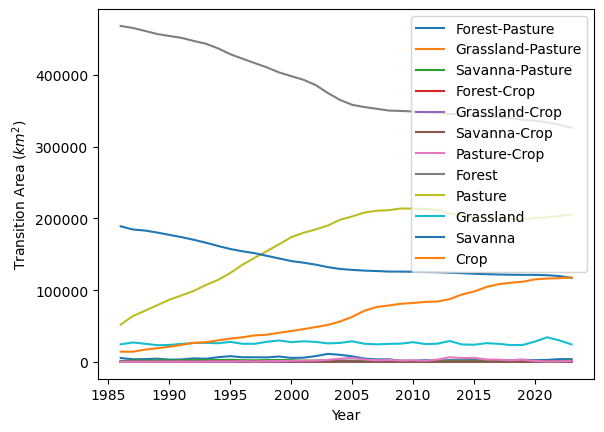

In [15]:
lulc_trans_area_df_to_plot = lulc_transitions_area_df.copy()
lulc_trans_area_df_to_plot.index = lulc_trans_area_df_to_plot.index + ZERO_YEAR_AFTER
ax = lulc_trans_area_df_to_plot[rename_dict.keys()].rename(columns=rename_dict).plot()
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')

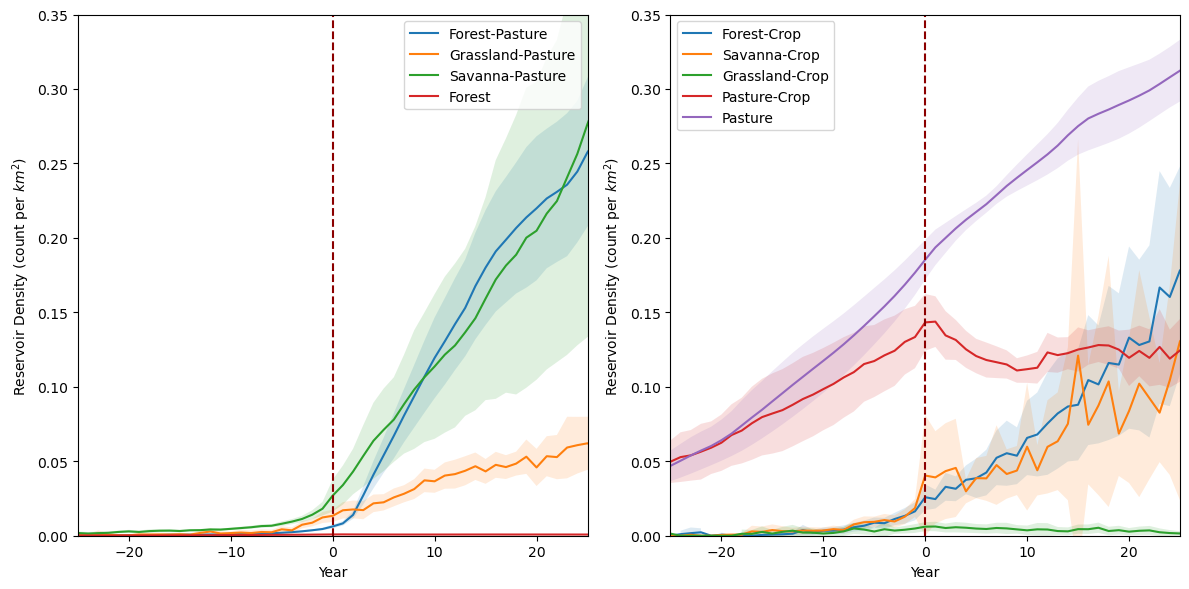

In [16]:

# Together
fig, axs = plt.subplots(1,2, figsize=(12,6))
mean_traj_toplot = mean_trajectories[['Forest-Pasture','Grassland-Pasture', 'Savanna-Pasture', 'Forest']]
mean_traj_toplot.plot(xlim=[-25, 25],ylim=[0,0.35], ax=axs[0])
for cover_type in mean_traj_toplot.columns:
    axs[0].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
mean_traj_toplot = mean_trajectories[['Forest-Crop','Savanna-Crop',  'Grassland-Crop', 'Pasture-Crop', 'Pasture']]
mean_traj_toplot.plot(xlim=[-25, 25], ylim=[0,0.35], ax=axs[1])
for cover_type in mean_traj_toplot.columns:
    axs[1].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
for i, ax in enumerate(axs):
    ax.set_xlabel('Year')
    ax.set_ylabel('Reservoir Density (count per $km^2$)')
    ax.axvline(0,color='darkred', linestyle='--')
fig.tight_layout()
plt.show()

# Simplify: Nature, Pasture, Crop

In [17]:
transition_regroup_dict = {
    'Natural-Pasture': ['forest-pasture', 'savanna-pasture','grassland-pasture'],
    'Natural-Crop': ['forest-crop', 'savanna-crop','grassland-crop'],
    'Pasture-Crop': ['pasture-crop'],
    'Natural-Natural': ['forest-forest','savanna-savanna','grassland-grassland'],
    'Pasture-Pasture': ['pasture-pasture'],
}

lulc_transitions_area_simple_df = pd.DataFrame({'year':lulc_transitions_area_df.index}).set_index('year')
for key, val in transition_regroup_dict.items():
    lulc_transitions_area_simple_df.loc[:, key] = lulc_transitions_area_df[val].sum(axis=1)

In [18]:
# Group trajectories into nature, crop, pasture
regroup_dict = {
    'pasture': 'Pasture',
    'forest': 'Natural',
    'savanna': 'Natural',
    'grassland': 'Natural',
    'crop': 'Crop'
}

normalized_dfs_simple_sum = []
normalized_dfs_simple_count = []
for res_y in res_year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile').replace(regroup_dict)
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    # lulc_df.columns = list(lulc_df.columns.astype(int)) 
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True,only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_simple_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_simple_sum.append(trans_df_sum)
    normalized_dfs_simple_count.append(trans_df_count)


In [19]:
simple_full_normalized_df = pd.concat(normalized_dfs_simple_count)
simple_full_normalized_df.index = simple_full_normalized_df.index - ZERO_YEAR_AFTER
simple_mean_trajectories = simple_full_normalized_df.groupby(level=0).mean()
simple_std_trajectories = simple_full_normalized_df.groupby(level=0).std()
simple_count_trajectories = simple_full_normalized_df.groupby(level=0).count()
simple_ci_low_df = simple_count_trajectories.copy()
simple_ci_high_df = simple_count_trajectories.copy()

In [20]:
for trans_type in simple_ci_low_df.columns:
    simple_ci_low_df[trans_type] = simple_full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_low)
    simple_ci_high_df[trans_type] = simple_full_normalized_df[trans_type].groupby(level=0).apply(calc_interval_high)

/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ksolvik/miniconda3/envs/resgis/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ks

<Figure size 735x300 with 0 Axes>

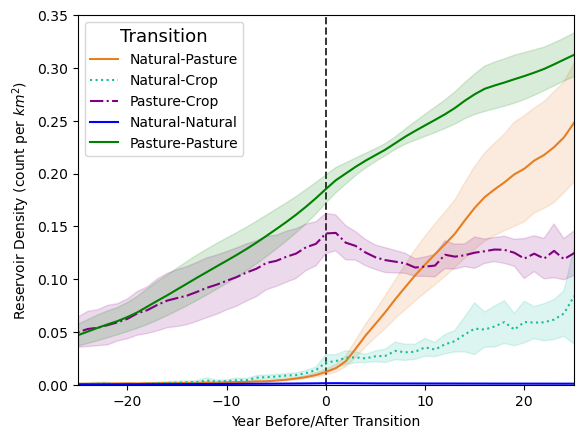

In [21]:
# color_list = ['#ad5100','#1f8d49','purple']
# color_list = ['#c0392b','black','purple']
color_list = ['#E67E22','#1ABC9C','purple', 'blue','green']
linestyle_list = ['-',':','-.', '-','-']
fig = plt.figure(figsize=(7.35, 3))
ax = simple_mean_trajectories.plot(xlim=[-25, 25],ylim=[0,0.35], color = color_list, style=linestyle_list, legend=False)
ax.legend(loc='upper left', 
        #   title=r'$\bf{Transition}$',
          title='Transition',
          title_fontsize=13)
i=0
for cover_type in simple_mean_trajectories.columns:
    ax.fill_between(simple_mean_trajectories.index,
                    (simple_ci_low_df)[cover_type],
                    (simple_ci_high_df)[cover_type],
                    alpha=0.15,
                    color=color_list[i])
    i += 1
# colors=['C0','C1','C2']
# for i,cover_type in enumerate(simple_mean_trajectories.columns):
#     ax.scatter(simple_full_normalized_df.index, simple_full_normalized_df[cover_type],
#                alpha=0.3,color=colors[i], edgecolors='none',s=18)
ax.set_xlabel('Year Before/After Transition')
ax.set_ylabel('Reservoir Density (count per $km^2$)')
ax.axvline(0.062, color='black', linestyle='--', zorder=-100, alpha=0.8,lw=1.4)

In [22]:
rename_dict

{'forest-pasture': 'Forest-Pasture',
 'grassland-pasture': 'Grassland-Pasture',
 'savanna-pasture': 'Savanna-Pasture',
 'forest-crop': 'Forest-Crop',
 'grassland-crop': 'Grassland-Crop',
 'savanna-crop': 'Savanna-Crop',
 'pasture-crop': 'Pasture-Crop',
 'forest-forest': 'Forest',
 'pasture-pasture': 'Pasture',
 'grassland-grassland': 'Grassland',
 'savanna-savanna': 'Savanna',
 'crop-crop': 'Crop'}

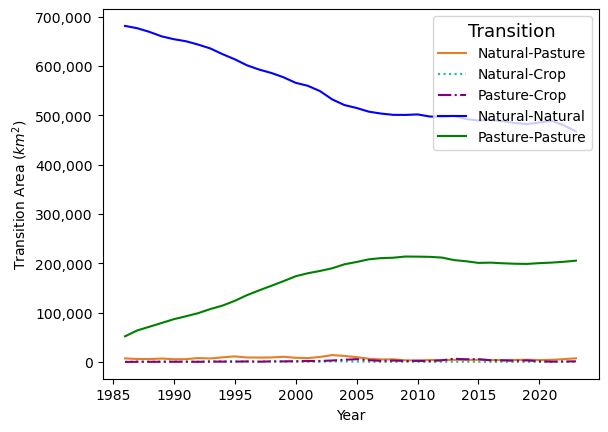

In [23]:
# ax = lulc_transitions_area_simple_df.plot(color=color_list, style=linestyle_list)
lulc_trans_area_simple_df_to_plot = lulc_transitions_area_simple_df.copy()
lulc_trans_area_simple_df_to_plot.index = lulc_trans_area_simple_df_to_plot.index + ZERO_YEAR_AFTER
ax = lulc_trans_area_simple_df_to_plot.plot(
    color=color_list, style=linestyle_list
)
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')
ax.legend(loc='upper right', 
        #   title=r'$\bf{Transition}$',
          title='Transition',
          title_fontsize=13)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# General LULC fig

In [24]:
annual_lulc = pd.read_csv('./csvs/lulc_summary_mt.csv').set_index('year')
annual_lulc*= (900/1000000)
annual_lulc['Total Agricultural'] = annual_lulc['pasture'] +  annual_lulc['crop']
annual_lulc.rename(columns={'pasture': 'Pasture', 'crop': 'Crop'}, inplace=True)
annual_lulc.index = annual_lulc.index.astype(int)

In [25]:
yearof_res_list = []
for res_y in range(1985, 2020):
    yearof_res_list.append(pd.read_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(res_y))[str(res_y)])

In [26]:
yearof_counts_by_lulc = [df.value_counts() for df in yearof_res_list]
annual_res_lulc = pd.concat(yearof_counts_by_lulc, axis=1).T

In [27]:

annual_res_lulc = annual_res_lulc#.drop(columns=['other', 'forest'])
annual_res_lulc = annual_res_lulc.rename(columns={'crop': 'Crop','pasture':'Pasture'})
annual_res_lulc['Total Agricultural'] = annual_res_lulc['Crop'] + annual_res_lulc['Pasture']
annual_res_lulc.index = annual_res_lulc.index.astype(int)
annual_res_lulc.columns.name = None
annual_res_lulc_density = annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']]/annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].loc[:2019].values
annual_res_lulc_density.index = annual_res_lulc_density.index.astype(int)

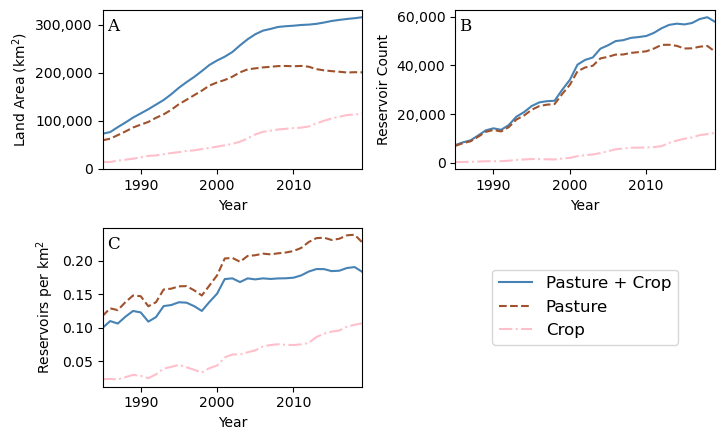

In [28]:
ag_class_color_list = ['steelblue', 'sienna', 'pink']
# Together
fig, axs = plt.subplots(2,2, figsize=(7.35,4.5))
annual_lulc.loc[:2019][['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[0, 0], color=ag_class_color_list, style=['-','--','-.'], legend=False)
annual_res_lulc.loc[:2019][['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[0, 1], color=ag_class_color_list, style=['-','--','-.'], legend=False)
annual_res_lulc_density.loc[:2019][['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[1,0], color=ag_class_color_list, style=['-','--','-.'], legend=False)
for ax in axs.flatten()[:3]:
    ax.set_xlabel('Year')
    ax.set_xlim([1985, 2019])
axs[0,0].set_ylabel('Land Area (km$^2$)')
axs[0, 1].set_ylabel('Reservoir Count')
axs[1,0].set_ylabel('Reservoirs per km$^2$')
# axs[0].set_title('Total Agricultural Area')
# axs[1].set_title('Reservoir Count by LULC Class')
# axs[2].set_title('Reservoir Density by LULC Class')
# Set up legend
axs[1, 1].set_axis_off()
handles, labels = axs[0,0].get_legend_handles_labels()
    
axs[1,1].legend(handles=handles, labels=['Pasture + Crop','Pasture','Crop'], loc=10,
            fontsize=12)
# axs[1,1].legend(loc='lower right', labels=['Pasture + Crop','Pasture','Crop'])
for i, label in enumerate(['A', 'B', 'C']):
    axs.flatten()[i].annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(0.25, -1.5), textcoords='offset fontsize',
            fontsize=12, verticalalignment='bottom', fontfamily='serif')

axs[0, 0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axs[0, 1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
fig.tight_layout()
plt.show()

# Single year plot

In [29]:
target_years = np.arange(1990, 2011, 10)

In [30]:
simple_full_normalized_df_wyears = simple_full_normalized_df.copy()
simple_full_normalized_df_wyears['res_year'] = np.repeat(res_year_range, res_year_range.shape[0])
simple_full_normalized_df_wyears['trans_year'] = (simple_full_normalized_df_wyears['res_year']-simple_full_normalized_df_wyears.index)+1

In [31]:
# First some quick calcs used for the methods discussion
y=2000
print(lulc_transitions_area_simple_df.loc[y-1])
print(simple_full_normalized_df_wyears.loc[
    simple_full_normalized_df_wyears['trans_year']==y].drop(
        columns=['trans_year'])['Natural-Pasture']*lulc_transitions_area_simple_df.loc[y-1, 'Natural-Pasture'])
print(simple_full_normalized_df_wyears.loc[
    simple_full_normalized_df_wyears['trans_year']==y].drop(
        columns=['trans_year'])['Natural-Pasture'])

Natural-Pasture      8423.0217
Natural-Crop          503.7228
Pasture-Crop         1537.5258
Natural-Natural    566012.1186
Pasture-Pasture    173746.4814
Name: 1999, dtype: float64
-14     18.0
-13     19.0
-12     22.0
-11     24.0
-10     18.0
-9      18.0
-8      12.0
-7       9.0
-6      14.0
-5      19.0
-4      26.0
-3      34.0
-2      49.0
-1      64.0
 0      75.0
 1      83.0
 2     129.0
 3     196.0
 4     277.0
 5     412.0
 6     480.0
 7     551.0
 8     574.0
 9     617.0
 10    642.0
 11    679.0
 12    706.0
 13    726.0
 14    710.0
 15    745.0
 16    728.0
 17    747.0
 18    749.0
 19    762.0
 20    729.0
Name: Natural-Pasture, dtype: float64
-14    0.002137
-13    0.002256
-12    0.002612
-11    0.002849
-10    0.002137
-9     0.002137
-8     0.001425
-7     0.001069
-6     0.001662
-5     0.002256
-4     0.003087
-3     0.004037
-2     0.005817
-1     0.007598
 0     0.008904
 1     0.009854
 2     0.015315
 3     0.023270
 4     0.032886
 5     0.048914
 6   

In [32]:
def update_prop(handle, orig):
    handle.update_from(orig)
    x,y = handle.get_data()
    handle.set_data([np.mean(x)]*2, [0, 2*y[0]])

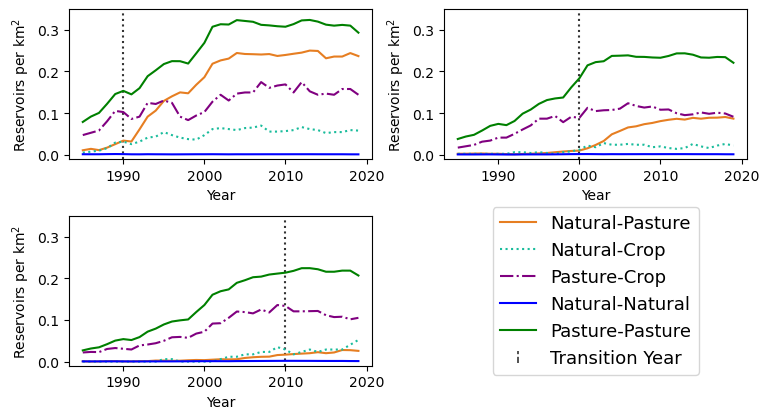

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 4))
for i, ax in enumerate(axs.flatten()):
    if i < (len(target_years)):
        y = target_years[i]
        simple_full_normalized_df_wyears.loc[
            (simple_full_normalized_df_wyears['trans_year']==y) &
            (simple_full_normalized_df_wyears['res_year']<2020)].drop(
                columns=['trans_year']).plot(ax=ax, x='res_year', legend=False, color=color_list, style=linestyle_list)
        ax.axvline(y,color='black', linestyle=':', alpha=0.8, zorder=-100)
        ax.set_xlabel('Year')
        ax.set_ylabel('Reservoirs per km$^2$')
        # ax.set_title(y) 
        # ax.set_xlim([1985, 2019])
        ax.set_ylim([-0.01, 0.35])
        prev_ax = ax
    # Add legend
    else:
        ax.set_axis_off()
        handles, labels = prev_ax.get_legend_handles_labels()
        vert_line = matplotlib.lines.Line2D(
            [0, 1],[1,1], color='black',lw=1.2, alpha=0.8, linestyle='--')
        handles.append(vert_line)
            
        labels.append('Transition Year')

        ax.legend(handles, labels,loc=10,
                   fontsize=13, markerscale=2,
                   handler_map={vert_line:HandlerLine2D(update_func=update_prop)}) 
fig.tight_layout(pad=0)

# Simplest figure: Number and area of reservoirs over time in MT

In [34]:
def read_process_basicstats(res_y):
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile')
    # lulc_df['area_ha'] = lulc_df['area']*100/10000
    # lulc_df = lulc_df.loc[lulc_df['area_ha']<100]
    out_dict = {
        'year': res_y,
        'count': lulc_df.shape[0],
        # 'area': lulc_df['area'].sum()
    } 
    return out_dict

all_dicts = [read_process_basicstats(res_y) for res_y in res_year_range]

In [35]:
basic_stats_df = pd.DataFrame(all_dicts).set_index('year')
# basic_stats_df['area_ha'] = basic_stats_df['area']*100/10000 # HA
# basic_stats_df['area_km'] = basic_stats_df['area']*100/(1000*1000) # km2
basic_stats_df['count_k'] = basic_stats_df['count']/1000

In [36]:
color_dict = {'ls5': '#66c2a5',
              'ls7': '#fc8d62',
              'ls8': '#8da0cb'}

In [37]:
# Calculate which landsats for which years
ls_year_dict = {
    'ls5':np.arange(1985, 2001),
    'ls7': np.arange(2001, 2020),
    'ls8': np.arange(2020, 2023)
}

ls_list = []
for res_y in res_year_range:
    for key, value in ls_year_dict.items():
        if res_y in value:
            ls_list.append(key)

basic_stats_df['satellite'] = ls_list
year_satellite = basic_stats_df.reset_index().set_index('year')[['satellite']]

In [38]:

def get_ls_color(y):
    return color_dict[year_satellite.loc[y].values[0]]

def color_by_ls(df, column, ax):
    year_values = np.stack([df.index.get_level_values('year'),
                            df[column]],
                       axis=1)
    for start, stop in zip(year_values[:-1],year_values[1:]):
        x, y = zip(start, stop)
        ls_shortname = year_satellite.loc[x[0]].values[0]
        ls_name = 'Landsat {}'.format(ls_shortname[-1])
        if ls_name not in ax.get_legend_handles_labels()[1]:
            ax.plot(x, y, color=get_ls_color(x[0]), lw=2.5, label=ls_name,
                   solid_capstyle='round')
        else:
            ax.plot(x, y, color=get_ls_color(x[0]), lw=2.5,
                   solid_capstyle='round')

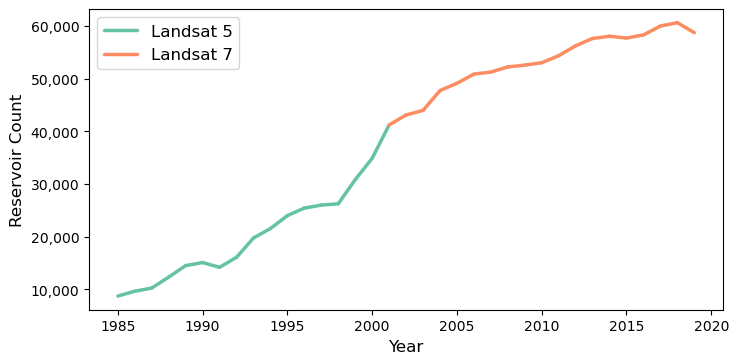

In [39]:

fig, axs = plt.subplots(1,1, figsize=(7.5,3.75))
# color_by_ls(basic_stats_df, 'count_k', axs)
axs.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
color_by_ls(basic_stats_df.loc[basic_stats_df['satellite']!='ls8'], 'count', axs)
axs.set_ylabel('Reservoir Count', fontsize=12)
axs.set_xlabel('Year', fontsize=12)
axs.legend(fontsize=12)
fig.tight_layout()

# Pie charts of transitions

In [40]:
last_transition_df = pd.read_csv('./out/most_recent_transitions.csv',index_col=0).drop(columns=['total_pasture','total_crop'])
# Simplify origins
last_transition_df['natural'] = last_transition_df[['grassland','savanna','forest']].sum(axis=1)
last_transition_df = last_transition_df.drop(columns=['grassland','savanna','forest'])
last_transition_df.columns = [c.capitalize() for c in last_transition_df.columns]

In [41]:

pie_color_list = ["pink", 'sienna', 'teal',"slategrey", "darkgreen"]

Text(0.5, 1.0, 'Crop')

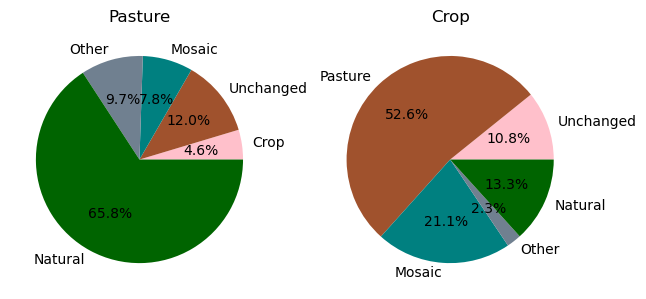

In [42]:
fig, axs = plt.subplots(1,2, figsize=[7.35,5])
pasture_df = last_transition_df.loc['pasture'].rename({'Pasture': 'Unchanged'})
crop_df = last_transition_df.loc['crop'].rename({'Crop': 'Unchanged'})
pasture_df.plot.pie(ax=axs[0], legend=False, autopct='%1.1f%%', colors=pie_color_list)
crop_df.plot.pie(ax=axs[1], legend=False, autopct='%1.1f%%', colors=pie_color_list)
for ax in axs:
    ax.set_ylabel(None)
axs[0].set_title('Pasture')
axs[1].set_title('Crop')